In [79]:
import wget
#download the bbc csv file
url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv'
wget.download(url)
import tensorflow as tf
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

100% [..........................................................................] 5057493 / 5057493

In [105]:
vocab_size = 1000  #size of the vocabulry to use
embedding_dim = 16  #dimensions of the vector used to represent each word
max_length = 120    #maximum lenght of the vector used to represent a single row 
trunc_type = 'post'    #type of truncation, if the dim is exceeded the last part is truncated
padding_type = 'post'  #type of paddig, zeros are added at the end
oov_tok = "<00V>"      #coding used to represent out of vocabulary words 
training_portion = 0.8

In [81]:
#Stopwords list from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

153


In [106]:
#preprocess file to obtain sentences and labels vectors
sentences = []
labels = []
with open("bbc-text.csv", 'r') as csvfile:  #open csv file
    reader = csv.reader(csvfile, delimiter = ',')  #read csv file
    next(reader)  #skip first row with labels
    for row in reader:
        labels.append(row[0])  #save every first element of row in the label vector
        sentence = row[1]      #preliminarly save the rest of the row in sentence
        for word in stopwords: #go through the stopwords
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
            sentence = sentence.replace(" ", " ")          #remove the sropwords from the sentences
        sentences.append(sentence)

print(len(sentences))
#print((sentences[0]))

2225


In [107]:
sep_len = int(training_portion*len(sentences))  #define separation between training and validation data
train_sentences = sentences[0:sep_len]   #first divide sentences
test_sentences = sentences[sep_len:]
train_labels = labels[0:sep_len]    #then labels
test_labels = labels[sep_len:]
print(sep_len)
print(len(train_sentences))
print(len(train_labels))
print(len(test_sentences))
print(len(test_labels))

1780
1780
1780
445
445


In [108]:
tokenizer =  Tokenizer(num_words = vocab_size, oov_token=oov_tok)   #define out of vocabolary identification and number of words
tokenizer.fit_on_texts(train_sentences)           #create the vocabulary index based on word frequency
word_index = tokenizer.word_index           #dictionary 
print(len(word_index))
#print(word_index)

27285


In [127]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)    #Transform each text in texts to a sequence of integers
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length, truncating= trunc_type)    #add padding, i.e. zeros, at the end to have same lenght 

test_sequences = tokenizer.texts_to_sequences(test_sentences)    #Transform each text in texts to a sequence of integers
test_padded = pad_sequences(test_sequences, padding = padding_type, maxlen = max_length, truncating= trunc_type)    #add padding, i.e. zeros, at the end to have same lenght 

In [128]:
label_tokenizer = Tokenizer()                           #same as before, but with the labels
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

In [111]:
import numpy as np   #trasform list in numpy array (later )
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)

In [120]:
#create  the mdel 

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='sigmoid')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 24)                408       
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 150       
Total params: 160,558
Trainable params: 160,558
Non-trainable params: 0
_________________________________________________________________


In [121]:
num_epochs = 30
history = model.fit(train_padded,training_label_seq, epochs = num_epochs, validation_data= (test_padded, validation_label_seq ), verbose = 2 )

Train on 1780 samples, validate on 445 samples
Epoch 1/30
1780/1780 - 0s - loss: 1.7764 - accuracy: 0.1938 - val_loss: 1.7567 - val_accuracy: 0.1933
Epoch 2/30
1780/1780 - 0s - loss: 1.7270 - accuracy: 0.1882 - val_loss: 1.6919 - val_accuracy: 0.1978
Epoch 3/30
1780/1780 - 0s - loss: 1.6499 - accuracy: 0.2129 - val_loss: 1.6125 - val_accuracy: 0.3146
Epoch 4/30
1780/1780 - 0s - loss: 1.5783 - accuracy: 0.3854 - val_loss: 1.5499 - val_accuracy: 0.3618
Epoch 5/30
1780/1780 - 0s - loss: 1.5057 - accuracy: 0.4713 - val_loss: 1.4626 - val_accuracy: 0.6180
Epoch 6/30
1780/1780 - 0s - loss: 1.3618 - accuracy: 0.7067 - val_loss: 1.2670 - val_accuracy: 0.6899
Epoch 7/30
1780/1780 - 0s - loss: 1.0834 - accuracy: 0.7427 - val_loss: 0.9647 - val_accuracy: 0.7506
Epoch 8/30
1780/1780 - 0s - loss: 0.7841 - accuracy: 0.8101 - val_loss: 0.7333 - val_accuracy: 0.7528
Epoch 9/30
1780/1780 - 0s - loss: 0.5985 - accuracy: 0.8202 - val_loss: 0.6088 - val_accuracy: 0.8629
Epoch 10/30
1780/1780 - 0s - loss: 

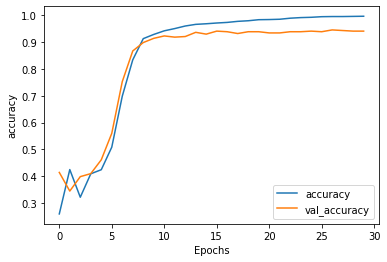

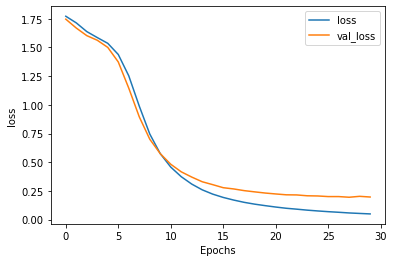

In [117]:
import matplotlib.pyplot as  plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [124]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(train_padded[0]))
print((train_padded[0]))
print(train_sentences[2])
print(labels[2])

tv future <00V> <00V> home theatre systems <00V> high <00V> <00V> digital video <00V> <00V> <00V> <00V> way people watch tv will <00V> different five years time according <00V> <00V> <00V> annual consumer <00V> show <00V> <00V> <00V> new technologies will impact one favourite <00V> us leading <00V> <00V> content will <00V> <00V> via home networks <00V> <00V> <00V> companies broadband service <00V> front <00V> portable devices one <00V> <00V> technologies <00V> digital personal video <00V> <00V> <00V> set top <00V> like us s <00V> uk s <00V> system allow people record <00V> play <00V> forward <00V> tv <00V> want <00V> technology <00V> much <00V> tv also <00V> in high <00V> tv <00V> big business japan us <00V> take off
[ 99 170   1   1  55 993 771   1  97   1   1 139 186   1   1   1   1  48
   9 907  99   4   1 347  93  24  17 140   1   1   1 585 465   1  65   1
   1   1  10 935   4 745  12 858   1  11 613   1   1 408   4   1   1 746
  55 552   1   1   1 144 262 123   1 809   1 994 599  

In [125]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(1000, 16)


In [126]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()